## TENSOR FLOW PARA PRINCIPIANTES (IV): Uso de la API Layers


Como hemos visto en el tutorial anterior (ver [Tutorial III]), se discutió la importancia de usar librerías o API
para construir o generar la estructura de los grafos de las redes neuronales en TensorFlow, ya que estas herramientas de desarrollo facilitan la implementación y modificación del código fuente, así como la redución en el riesgo de cometer errores en los mismos. Para mostrar como iplementar estas API, en el [Tutorial III] hemos empleado la API de construcción de grafos en TensorFlow llamada PrettyTensor. Pero hay varias otras API de compilación disponibles para TensorFlow. 


Este tutorial trata de como implementar otra API agregada a TensorFlow llamada "*Layers*" o " *The API Layres* " o por su nombre en Python tf.layers. Esta API generadora de grafos se instala automáticamente como parte de TensorFlow, por lo que ya no tiene que instalar un paquete de Python por separado, como se necesitaba con PrettyTensor. 

Este tutorial es muy similar al [Tutorial III] en PrettyTensor y muestra cómo implementar la misma red neuronal convolucional utilizando la API de capas. Se recomienda que esté familiarizado con los tutoriales [II] y [III] publicados anteriormente. 

Antes de continuar, recordemos el esquema de la red neuronal convolucinal que queremos implementar para la tarea del reconocimiento de dígitos escritos a mano, para ello veamos la siguinete imagen ya empleada en el [Tutorial II]. 


![F1](imagenes/02_network_flowchart.png)


Comenzamos por importar algunas librerias,



[II]:https://www.apsl.net/blog/2017/12/18/tensor-flow-para-principiantes-ii/
[Tutorial II]:https://www.apsl.net/blog/2017/12/18/tensor-flow-para-principiantes-ii/

[III]:https://www.apsl.net/blog/2018/01/10/tensor-flow-para-principiantes-iii-uso-de-la-libreria-prettytensor/

[Tutorial III]:https://www.apsl.net/blog/2018/01/10/tensor-flow-para-principiantes-iii-uso-de-la-libreria-prettytensor/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math

Cargamos el conjunto de datos MNIST que se descargará automáticamente si no se encuentra en la ruta dada.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Chequemaos que todo está correcto

In [3]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


Las etiquetas de clase son codificadas por One-Hot, lo que significa que cada etiqueta es un vector con 10 elementos, todos los cuales son cero a excepción de un elemento. El índice de este elemento es el número de clase, es decir, el dígito que se muestra en la imagen asociada. También necesitamos los números de clase como enteros para el conjunto de pruebas, por lo que ahora lo calculamos.


In [4]:
data.test.cls = np.argmax(data.test.labels, axis=1)

Pasamos a definir el conjunto de variables para dar formato a las dimensiones de nuestras imágenes:

In [5]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

 Crearemos nuestra función que es utilizada para trazar 9 imágenes en una cuadrícula de 3x3 y escribir las clases verdaderas y predichas debajo de cada imagen.

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Graficamos algunas imágenes para ver si los datos son correctos

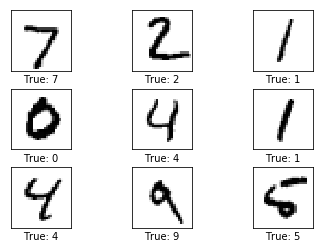

In [7]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

Las variables de marcador de posición (Placeholder variables)

Creamos las variables de marcador de posición como hicimos en el [Tutorial II]


In [8]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Implementación de la Red Convolucional usando la API Layres (tf.Layers)

Esta sección muestra cómo realizar exactamente la misma implementación de la red neuronal convolucional en el [Tutorial II] utilizando la API Layres.

Usamos la variable ** *net* ** para referirnos a la última capa mientras construimos la red neuronal. Esto facilita agregar o eliminar capas en el código. Primero establecemos la variable net a la imagen de entrada re-escalada (re-formateada).


In [9]:
net = x_image

La imagen de entrada se ingresa a la primera capa convolucional, que tiene 16 filtros cada uno de 5x5 píxeles de tamaño. La función de activación es la Unidad lineal rectificada (ReLU) descrita con más detalle en el [Tuturial II].

Definimos la capa convolucinal:

In [10]:
net = tf.layers.conv2d(inputs=net, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)

Una de las ventajas de construir redes neuronales de esta manera es que ahora podemos extraer fácilmente una referencia a una capa. Esto fue más complicado en PrettyTensor.

Además, a continuación queremos trazar la salida de la primera capa convolucional, por lo que creamos otra variable para mantener una referencia a esa capa. Vemaos:

In [11]:
layer_conv1 = net
print(layer_conv1)

Tensor("layer_conv1/Relu:0", shape=(?, 28, 28, 16), dtype=float32)


Ahora hacemos el max pooling en la salida de la capa convolucional. Esto también se describió con más detalle en el [Tutorial II].

In [12]:
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)
print(net)

Tensor("max_pooling2d/MaxPool:0", shape=(?, 14, 14, 16), dtype=float32)


Ahora agregamos la segunda capa convolucional que tiene 36 filtros cada uno con 5x5 píxeles, y una función de activación ReLU nuevamente.

In [13]:
net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)

También queremos obtener la salida de esta capa convolucional, por lo que guardamos una referencia para su uso posterior.

In [14]:
layer_conv2 = net
print(layer_conv2)

Tensor("layer_conv2/Relu:0", shape=(?, 14, 14, 36), dtype=float32)


La salida de la segunda capa convolucional también aplicamos el max-pooling.

In [15]:
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)
print(net)

Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 7, 7, 36), dtype=float32)


A continuación, queremos agregar capas totalmente conectadas a la red neuronal, pero estas requieren tensores de 2 rangos como entrada, por lo que primero debemos aplanar los tensores.

In [16]:
net = tf.layers.flatten(net)
print(net)

Tensor("flatten/Reshape:0", shape=(?, 1764), dtype=float32)


Esto ahora ha aplanado los datos a un tensor de 2 rangos

Ahora podemos agregar capas totalmente conectadas a la red neuronal. Estas se llaman capas densas en la API de capas.

In [17]:
net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)

Necesitamos la red neuronal para clasificar las imágenes de entrada en 10 clases diferentes. Entonces, la capa final totalmente conectada tiene num_classes = 10 neuronas de salida.

In [18]:
net = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)

La salida de la capa final totalmente conectada a veces se denomina logits, por lo que tenemos una variable de conveniencia con ese nombre.

In [19]:
logits = net

Usamos la función softmax para acotar las salidas para que estén entre cero y uno

In [20]:
y_pred = tf.nn.softmax(logits=logits)

Esto nos dice cuán probable es que la red neuronal crea que la imagen de entrada es de cada clase posible. El que tiene el valor más alto se considera el más probable, por lo que su índice se toma como el número de clase.

In [21]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Como se acaba de ocurrir, hemos creado exactamente la misma red neuronal convolucional en unas pocas líneas de código que requieren muchas líneas complejas de código en la implementación directa de TensorFlow.

La API Layers quizás no sea tan elegante como PrettyTensor, pero tiene algunas otras ventajas, como p. Ej. que podemos referirnos más fácilmente a las capas intermedias, y también es más fácil construir redes neuronales con ramas y salidas múltiples usando la API de capas.


Al igual que en los tutoriales antriores, vamos a preparar todas las funciones para ponerven marcha nuestro grafo.

#### Función de coste a optimizar

Para mejorar el modelo al clasificar las imágenes de entrada, de alguna manera debemos cambiar las variables de la Red Neural Convolucional.

La entropía cruzada es una medida de rendimiento utilizada en la clasificación. La entropía cruzada es una función continua que siempre es positiva y si la salida pronosticada del modelo coincide exactamente con la salida deseada, la entropía cruzada es igual a cero. El objetivo de la optimización es, por lo tanto, minimizar la entropía cruzada para que se acerque lo más posible a cero cambiando las variables del modelo.

TensorFlow tiene una función para calcular la entropía cruzada, que utiliza los valores de logits-layer porque también calcula el softmax internamente, para mejorar la estabilidad numérica.

In [22]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)

Ahora hemos calculado la entropía cruzada para cada una de las clasificaciones de imagen, por lo que tenemos una medida de qué tan bien funciona el modelo en cada imagen individualmente. Pero para utilizar la entropía cruzada para guiar la optimización de las variables del modelo, necesitamos un único valor escalar, por lo que simplemente tomamos el promedio de la entropía cruzada para todas las clasificaciones de imagen.

In [23]:
loss = tf.reduce_mean(cross_entropy)

### Método de optimización

Ahora que tenemos una medida de costos que debe minimizarse, podemos crear un optimizador. En este caso, es el optimizador de Adam con una tasa de aprendizaje de 1e-4.

Tenga en cuenta que la optimización no se realiza en este punto. De hecho, nada se calcula en absoluto, simplemente agregamos el objeto optimizador al gráfico TensorFlow para su posterior ejecución.

In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

Necesitamos calcular la precisión de la clasificación para que podamos informar el progreso al usuario.

Primero creamos un vector de booleanos que nos dice si la clase predicha es igual a la clase verdadera de cada imagen.

In [25]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

Calculamos la precisión (accuracy) de la clasificación y transforma los booleanos a floats, de modo que False se convierte en 0 y True se convierte en 1. Luego calculamos el promedio de estos números.

In [26]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Obteniendo los pesos

Ya que queremos graficar los pesos de las capas convolucionales. En la implementación de TensorFlow, nosotros mismos habíamos creado las variables para que pudiéramos referirnos a ellas directamente. Pero cuando la red se construye usando una API de generador como tf.layers, todas las variables de las capas son creadas indirectamente por la API del constructor. Por lo tanto, solo tenemos que recuperar las variables de TensorFlow.

Primero necesitamos una lista de los nombres de las variables en el gráfico TensorFlow:

In [27]:
for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    print(var)

<tf.Variable 'layer_conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv2/kernel:0' shape=(5, 5, 16, 36) dtype=float32_ref>
<tf.Variable 'layer_conv2/bias:0' shape=(36,) dtype=float32_ref>
<tf.Variable 'layer_fc1/kernel:0' shape=(1764, 128) dtype=float32_ref>
<tf.Variable 'layer_fc1/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'layer_fc_out/kernel:0' shape=(128, 10) dtype=float32_ref>
<tf.Variable 'layer_fc_out/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'layer_conv1/kernel/Adam:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/kernel/Adam_1:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias/Adam:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias/Adam_1:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv2/ke

Cada una de las capas convolucionales tiene dos variables. Para la primera capa convolucional se llaman layer_conv1 / kernel: 0 y layer_conv1 / bias: 0. Las variables del kernel son las que queremos recuperar más abajo.

Es algo incómodo obtener referencias a estas variables, porque tenemos que usar la función TensorFlow get_variable () que fue diseñada para otro propósito; ya sea creando una nueva variable o reutilizando una variable existente. Lo más fácil es hacer la siguiente función auxiliar.

In [28]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'kernel' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')

    return variable

Usando esta función auxiliar podemos recuperar las variables. Estos son objetos TensorFlow. Para obtener el contenido de las variables, debe hacer algo como: contents = session.run (weights_conv1) :

In [29]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

#### Ejecutamos el Grafo

Crear sesión de TensorFlow: Una vez que se ha creado el gráfico TensorFlow, tenemos que crear una sesión TensorFlow que se utiliza para ejecutar el gráfico.

In [30]:
session = tf.Session()

Inicialización de la variables 

In [31]:
session.run(tf.global_variables_initializer())

creamos la función de iteración para el proceso de optimización:

In [32]:
train_batch_size = 64
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

Ahora crearemos algunas funciones para el monitoreo del comportamiento del modelo.

* Función para trazar ejemplos de imágenes del conjunto de prueba que han sido clasificadas incorrectamente.


In [33]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

* Función para calcular la matriz de confusión 

In [34]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

* Función para imprimir la precisión de clasificación en el conjunto de prueba.

In [35]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

Miremos la precisión antes de cualquier optimización.

In [36]:
print_test_accuracy()

Accuracy on Test-Set: 7.4% (743 / 10000)


Como vemos, la precisión del modelo es muy baja. Tiene sentido, puesto que no hemos optimizado ningún parámetro.

Mirémos ahora depuès de una iteración en el proceso de optimización:

In [37]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  10.9%


In [38]:
print_test_accuracy()

Accuracy on Test-Set: 9.1% (910 / 10000)


como vemos como el modelo mejora un poco su precisión.

Rendimiento después de 100 iteraciones de optimización

In [39]:
%%time
optimize(num_iterations=99) # We already performed 1 iteration above.

CPU times: user 22.8 s, sys: 56 ms, total: 22.9 s
Wall time: 6.75 s


In [41]:
print_test_accuracy(show_example_errors=False)

Accuracy on Test-Set: 75.4% (7543 / 10000)


Después de 100 iteraciones de optimización, el modelo ha mejorado significativamente su precisión de clasificación.

Rendimiento después de 1000 iteraciones de optimización

In [42]:
%%time
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  81.2%
Optimization Iteration:    201, Training Accuracy:  89.1%
Optimization Iteration:    301, Training Accuracy:  89.1%
Optimization Iteration:    401, Training Accuracy:  95.3%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  92.2%
Optimization Iteration:    701, Training Accuracy:  92.2%
Optimization Iteration:    801, Training Accuracy:  95.3%
Optimization Iteration:    901, Training Accuracy:  96.9%
CPU times: user 3min 29s, sys: 908 ms, total: 3min 30s
Wall time: 59.9 s


In [43]:
print_test_accuracy(show_example_errors=False)

Accuracy on Test-Set: 95.1% (9511 / 10000)


Ahora 10 mil iteraciones...

In [44]:
%%time
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy:  95.3%
Optimization Iteration:   1101, Training Accuracy:  92.2%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Optimization Iteration:   1301, Training Accuracy: 100.0%
Optimization Iteration:   1401, Training Accuracy:  95.3%
Optimization Iteration:   1501, Training Accuracy:  95.3%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy:  98.4%
Optimization Iteration:   1801, Training Accuracy:  98.4%
Optimization Iteration:   1901, Training Accuracy:  98.4%
Optimization Iteration:   2001, Training Accuracy:  93.8%
Optimization Iteration:   2101, Training Accuracy:  92.2%
Optimization Iteration:   2201, Training Accuracy: 100.0%
Optimization Iteration:   2301, Training Accuracy:  98.4%
Optimization Iteration:   2401, Training Accuracy:  95.3%
Optimization Iteration:   2501, Training Accuracy:  96.9%
Optimization Iteration:   2601, Training Accuracy:  96.9%
Optimization I

Accuracy on Test-Set: 98.7% (9870 / 10000)
Confusion Matrix:
[[ 975    0    0    1    0    0    1    0    3    0]
 [   0 1130    1    0    0    0    1    1    2    0]
 [   2    1 1002   16    1    0    0    4    6    0]
 [   0    0    0 1008    0    1    0    0    1    0]
 [   0    0    1    0  978    0    1    0    0    2]
 [   2    0    0    7    0  881    1    0    0    1]
 [   7    2    0    1    1    6  938    0    3    0]
 [   0    1    3    5    0    0    0 1012    1    6]
 [   2    0    1    4    2    1    0    3  957    4]
 [   1    3    0    4    4    4    0    3    1  989]]


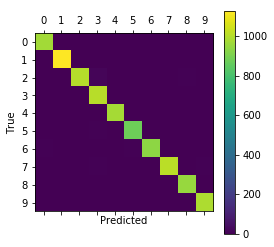

In [45]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

Visualizar los pesos de las capas convolucionales. Creamos una función apar ello

In [46]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Función auxiliar para trazar la salida de una capa convolucional

In [47]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Imágenes de entrada

Función auxiliar para trazar una imagen.

In [48]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Trazamos una imagen del conjunto de prueba.

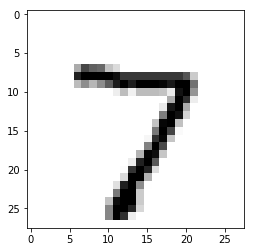

In [50]:
image1 = data.test.images[0]
plot_image(image1)

Trazamos otra:

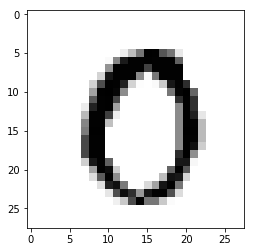

In [51]:
image2 = data.test.images[13]
plot_image(image2)

### Convolución Capa 1

Ahora grafica los pesos de filtro para la primera capa convolucional.

Tenga en cuenta que los pesos positivos son rojos y los negativos son azules.

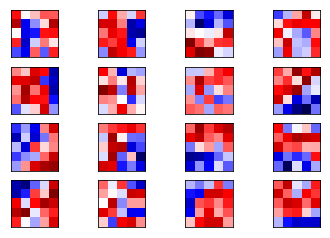

In [52]:
plot_conv_weights(weights=weights_conv1)

La aplicación de cada uno de estos filtros convolucionales a la primera imagen de entrada proporciona las siguientes imágenes de salida, que luego se utilizan como entrada a la segunda capa convolucional.

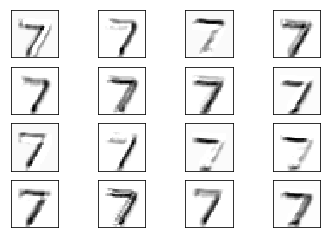

In [53]:
plot_conv_layer(layer=layer_conv1, image=image1)

para la imagen 2


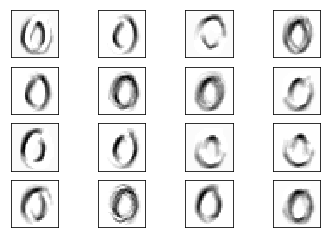

In [54]:
plot_conv_layer(layer=layer_conv1, image=image2)

### Convolution Layer 2

Ahora grafica los pesos de los filtros para la segunda capa convolucional. Dado que hay 16 canales de salida desde la primera capa convolucional, entonces tendremos 16 canales de entrada para la segunda capa convolucional. La segunda capa convolucional tiene un conjunto de filtros de los pesos para cada uno de sus canales de entrada. Comenzamos por graficar los pesos del filtro para el primer canal. Note nuevamente que los pesos positivos son rojos y los pesos negativos son azules.

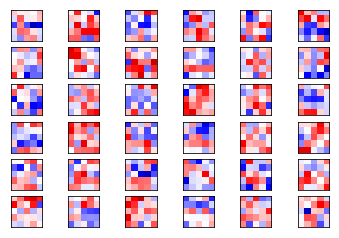

In [55]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

Para el canal 2

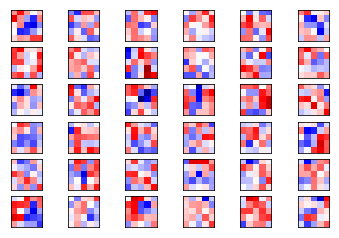

In [56]:
plot_conv_weights(weights=weights_conv2, input_channel=1)


Miramos los filtros convolucionales

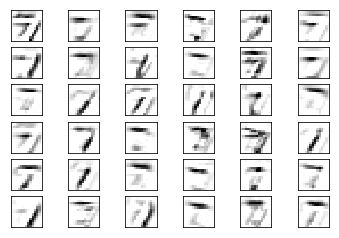

In [57]:
plot_conv_layer(layer=layer_conv2, image=image1)

para la imagen 2

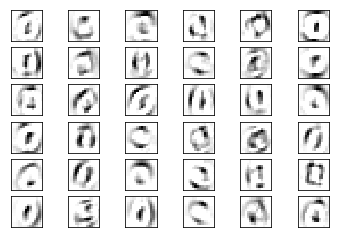

In [59]:
plot_conv_layer(layer=layer_conv2, image=image2)

Cerramos la sesion

In [61]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
session.close()

Este tutorial mostró cómo usar la  API Layers para construir fácilmente redes neuronales convolucionales en TensorFlow. La sintaxis es diferente y más detallada que la de PrettyTensor. Ambas API  tienen ventajas y desventajas y el uso dependerá de los proyectos a desarrollar.


